# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
import matplotlib.image as mpimg
import matplotlib as mpl

# Import API key
from g_key import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [3]:
# loading csv file
csv = '../output_data/cities.csv'
weather_data = pd.read_csv(csv)
weather_data.head()

City ID          City  Cloudiness Country        Date  Humidity    Lat  \
0        0       Mataura          99      NZ  1600107836        90 -46.19   
1        1        Atuona           6      PF  1600107837        77  -9.80   
2        2        Visnes          75      NO  1600107837        87  59.36   
3        3  Punta Arenas          40      CL  1600107837        65 -53.15   
4        4      Goderich          48      CA  1600107837        64  43.75   

      Lng  Max Temp  Wind Speed  
0  168.86      5.56        3.58  
1 -139.03     25.41        7.53  
2    5.22     15.00        3.60  
3  -70.92      7.00       14.40  
4  -81.72     17.22        5.90

### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [4]:
# configuring gmaps
gmaps.configure(api_key=g_key)

Figure(layout=FigureLayout(height='420px'))

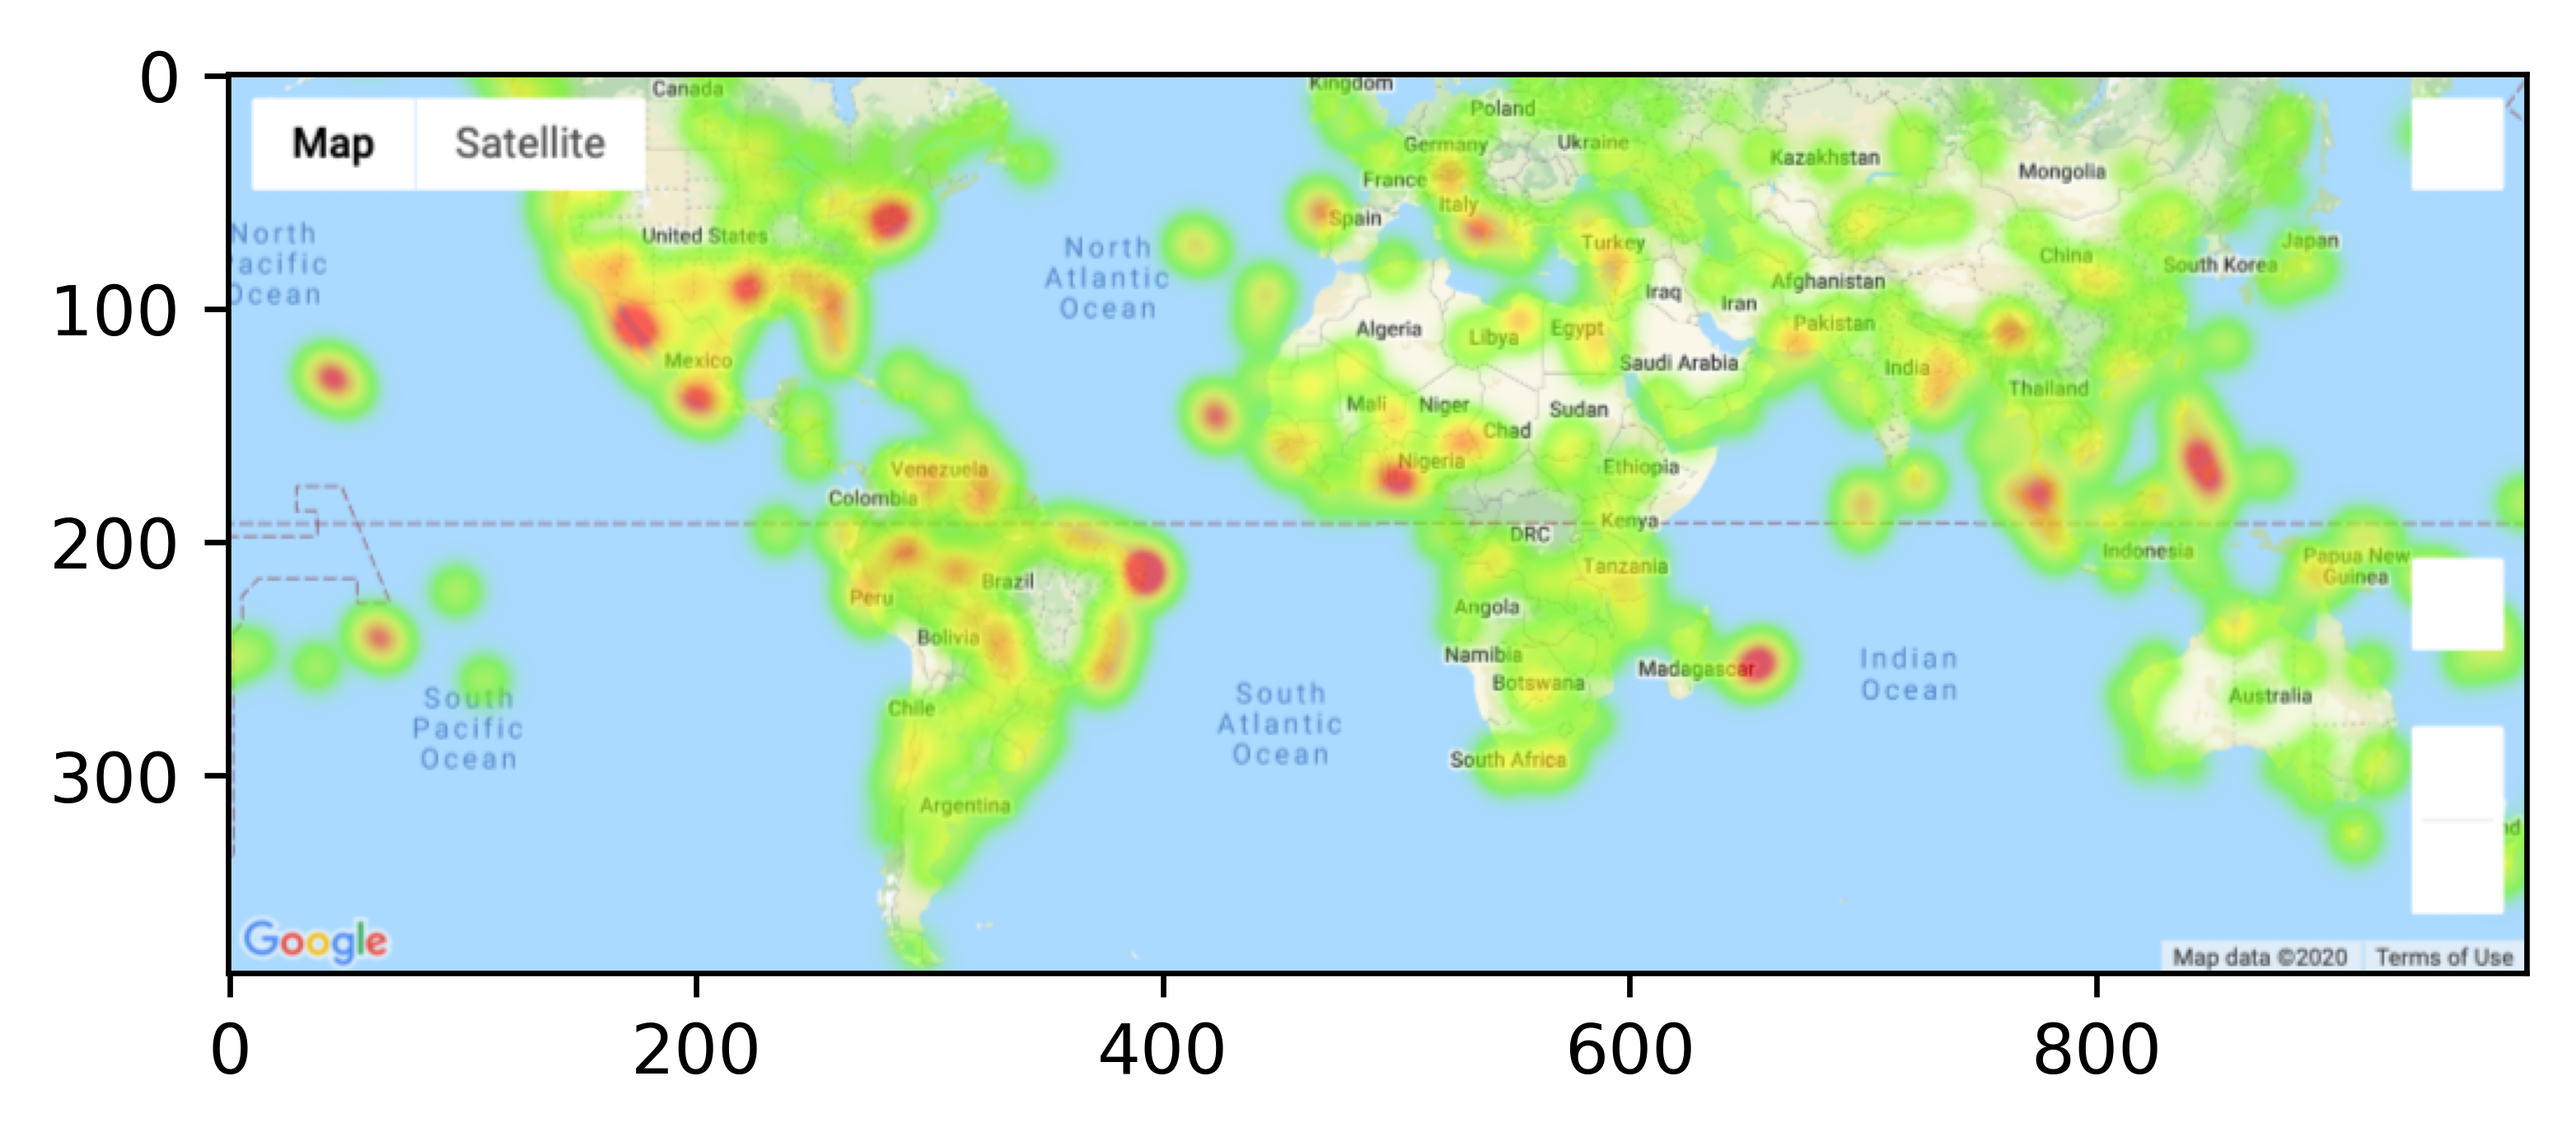

In [20]:
# Store 'Lat' and 'Lng' into  locations 
weather_data = weather_data.dropna()
intensity = weather_data['Humidity'].max()
cent= (0, 0)
weather_data = weather_data.loc[weather_data["Max Temp"] >= 0,:]
locations = weather_data[["Lat", "Lng"]].astype(float)
heat_data = weather_data["Max Temp"].astype(float)
fig = gmaps.figure(center=cent, zoom_level=2)
heat_layer = gmaps.heatmap_layer(locations, weights=heat_data, dissipating=False, max_intensity=intensity, point_radius = 5)
fig.add_layer(heat_layer)

# Display figure
img = mpimg.imread('../output_data/HeatMap.png')
imgplot = plt.imshow(img)
mpl.rcParams['figure.dpi'] = 600
fig

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [8]:
# Narrow down the cities to fit weather conditions
vacation_data = weather_data.loc[(weather_data["Max Temp"] >= 30) & 
                                 (weather_data["Max Temp"] < 40) &
                                 (weather_data["Humidity"] < 50) & 
                                 (weather_data["Cloudiness"] < 50) & 
                                 (weather_data["Wind Speed"] < 3)]
vacation_data = vacation_data.reset_index(drop=True)
vacation_data.head()

City ID        City  Cloudiness Country        Date  Humidity    Lat  \
0       45       Diffa          42      NE  1600107847        38  13.32   
1       94  Châteaudun           0      FR  1600107648        30  48.08   
2      117       Yaqui          20      MX  1600107867        46  27.37   
3      290    Canutama          45      BR  1600107920        31  -6.53   
4      299    Maracaju           8      BR  1600107923        13 -21.61   

      Lng  Max Temp  Wind Speed  
0   12.61     32.62        2.76  
1    1.33     30.00        1.50  
2 -110.17     33.00        1.00  
3  -64.38     37.63        1.25  
4  -55.17     37.86        2.98

### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [15]:
hotel_df = vacation_data
hotel_df["Hotel Name"]= ""

base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
params = {"radius": 5000,
          "type": "hotel",
          "key": g_key,}

for index, row in hotel_df.iterrows():
    latitude = str(row['Lat'])
    longitude = str(row['Lng'])
    target_coor = latitude + ", " + longitude
    params['location'] = target_coor
    response = requests.get(base_url, params=params)
    hotels_data = response.json()
    results = hotels_data['results']
    try:
        print(hotels_data["results"][0]["name"])
        hotel_df.loc[index, 'Hotel Name'] = results[0]['name']
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

Diffa
Châteaudun
Yaqui
Canutama
Maracaju
A.h Marginal Manuel Pacaya
Filingué
Las Vegas
Cercado de Tocache
St. George
Indio
Guerrero Negro


In [10]:
hotel_df

City ID            City  Cloudiness Country        Date  Humidity    Lat  \
0        45           Diffa          42      NE  1600107847        38  13.32   
1        94      Châteaudun           0      FR  1600107648        30  48.08   
2       117           Yaqui          20      MX  1600107867        46  27.37   
3       290        Canutama          45      BR  1600107920        31  -6.53   
4       299        Maracaju           8      BR  1600107923        13 -21.61   
5       400           Nauta          11      PE  1600107951        44  -4.51   
6       435        Filingué           7      NE  1600107963        30  14.35   
7       442       Las Vegas           1      US  1600107964         9  36.17   
8       450         Tocache          37      PE  1600107968        30  -8.18   
9       495    Saint George           1      US  1600107975        14  37.10   
10      497       Coachella           0      US  1600107981        21  33.68   
11      549  Guerrero Negro           0      MX  1600107995        30  27.98   

       Lng  Max Temp  Wind Speed                  Hotel Name  
0    12.61     32.62        2.76                       Diffa  
1     1.33     30.00        1.50                  Châteaudun  
2  -110.17     33.00        1.00                       Yaqui  
3   -64.38     37.63        1.25                    Canutama  
4   -55.17     37.86        2.98                    Maracaju  
5   -73.58     35.23        1.38  A.h Marginal Manuel Pacaya  
6     3.32     36.47        1.34                    Filingué  
7  -115.14     34.44        1.76                   Las Vegas  
8   -76.51     35.38        0.80          Cercado de Tocache  
9  -113.58     32.22        2.10                  St. George  
10 -116.17     35.56        0.89                       Indio  
11 -114.06     31.84        1.20              Guerrero Negro

In [21]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

Figure(layout=FigureLayout(height='420px'))

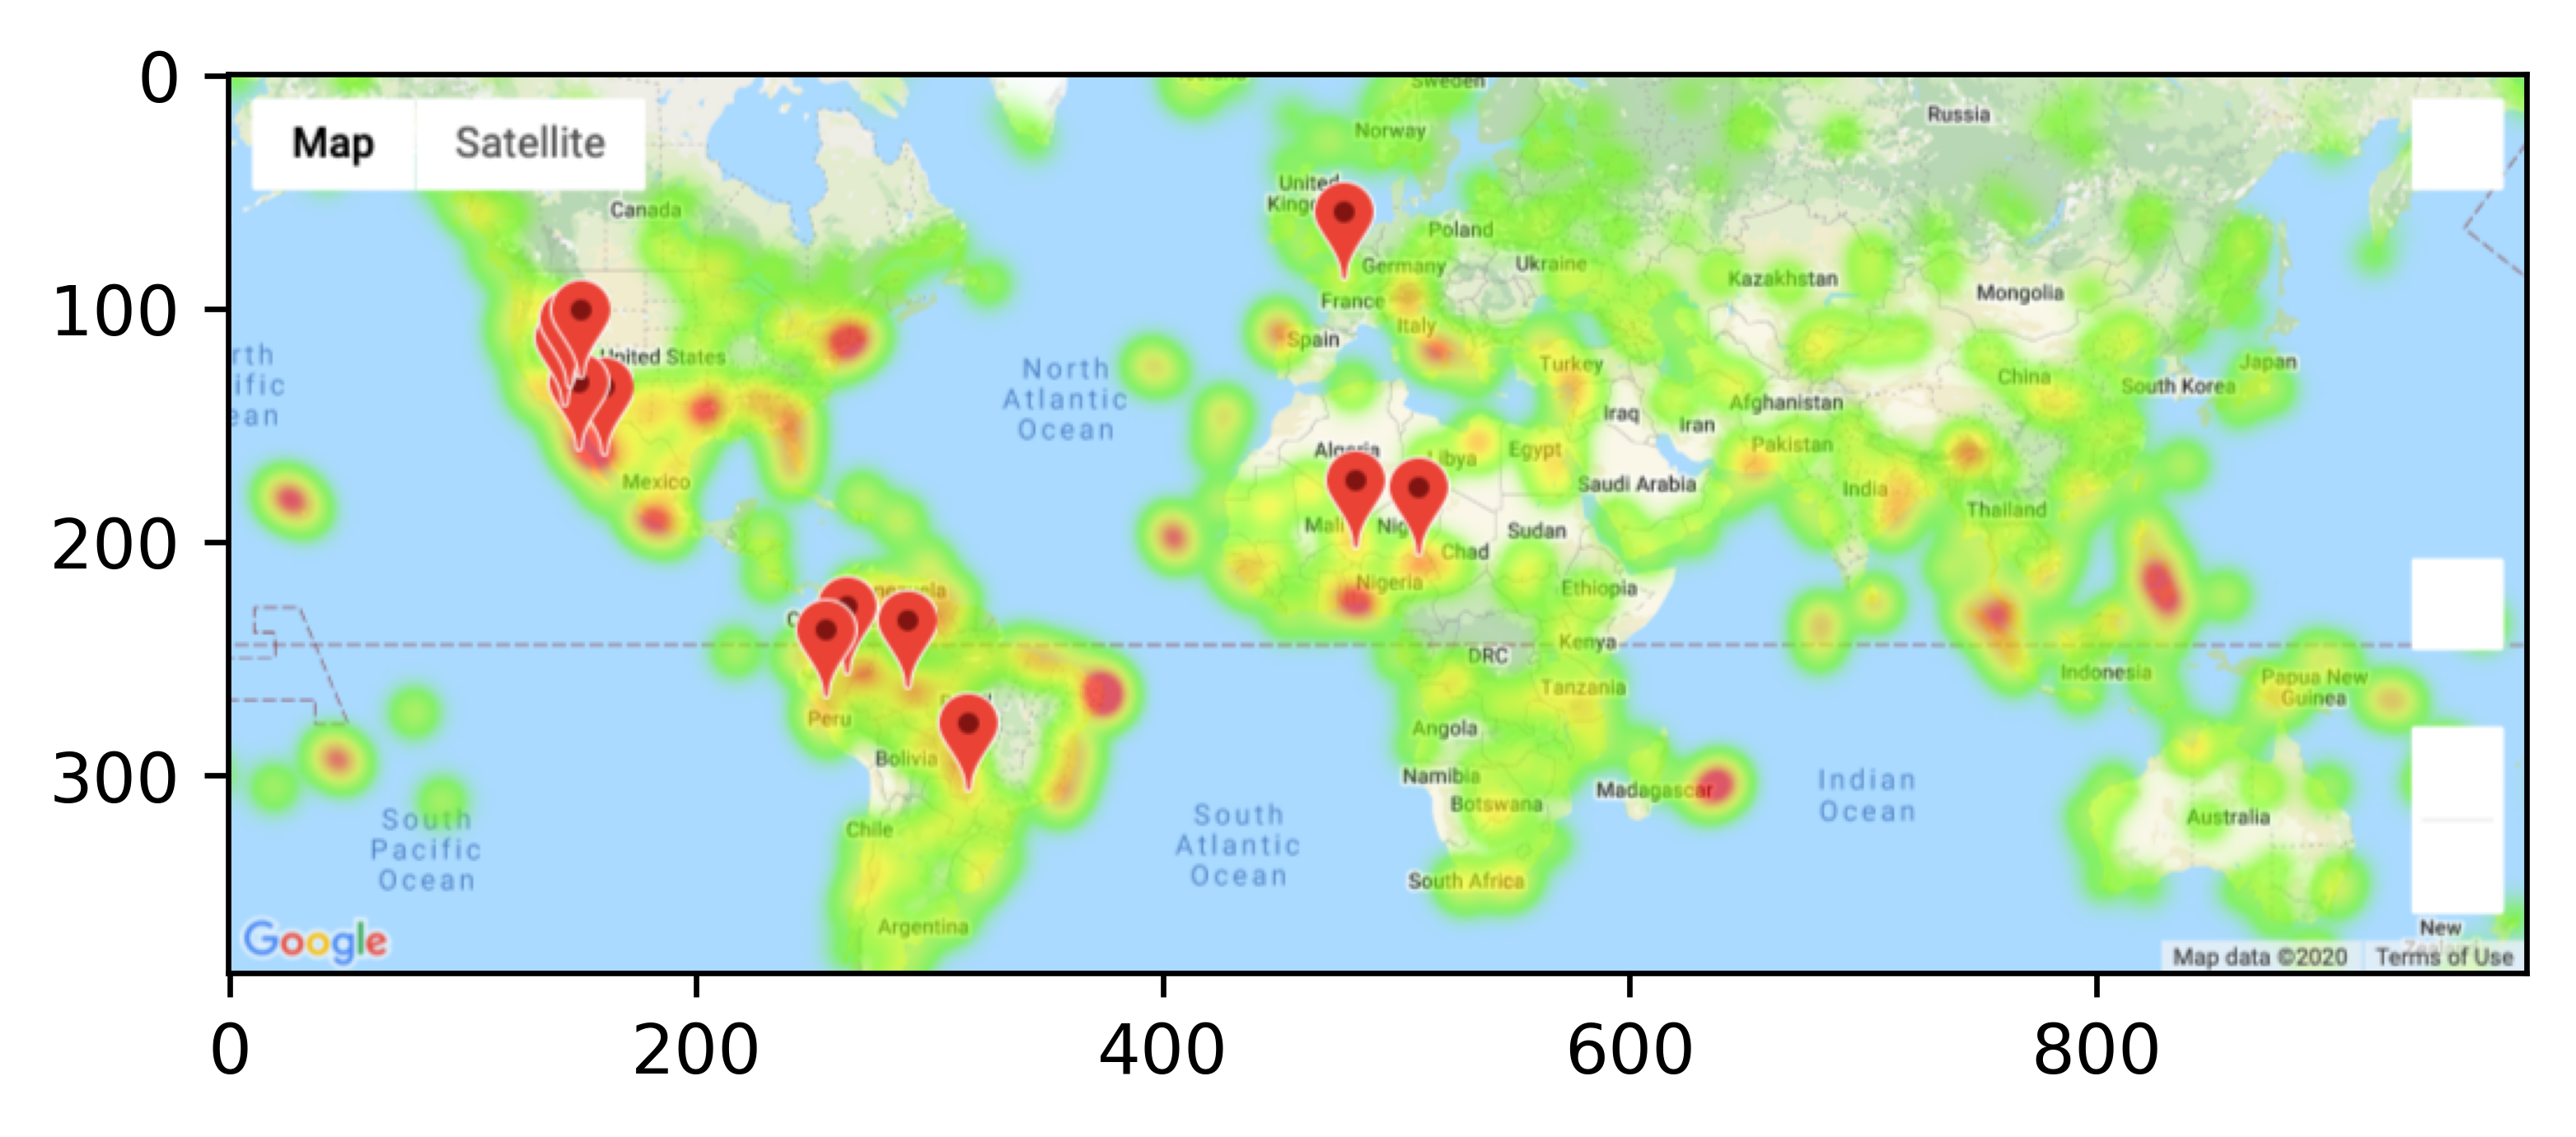

In [22]:
# Add marker layer on top of heat map
markers = gmaps.marker_layer(locations, info_box_content = hotel_info)
fig.add_layer(markers)

# Display figure
img = mpimg.imread('../output_data/HeatMap_Markers.png')
imgplot = plt.imshow(img)
mpl.rcParams['figure.dpi'] = 600
fig